In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import torch

sys.path.append("../")
from data_prep import collect, load
from solvers import branch_classifier
import models
date = datetime.now().strftime("%m-%d-%y")
dtype = torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Collect branch classifier training data

## Get sample points from swc files

In [6]:
# get sample points from swc files
labels_dir = "/Users/brysongray/alienware/data/neuromorpho"
samples_per_file = 1
files = [f for x in os.walk(labels_dir) for f in glob(os.path.join(x[0], '*.swc'))]
swc_lists = []
for f in files:
    swc_lists.append(load.swc(f))
fnames = [f.split('/')[-1].split('.')[0] for f in files]
sample_points = collect.swc_random_points(samples_per_file, swc_lists, fnames, adjust=True)

loading file: /Users/brysongray/alienware/data/neuromorpho/mehder/CNG version/Rasha-CA1-Exp-April-2016-right-slide-55-secion-1.CNG.swc
loading file: /Users/brysongray/alienware/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_5.CNG.swc
loading file: /Users/brysongray/alienware/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_3.CNG.swc
loading file: /Users/brysongray/alienware/data/neuromorpho/briggs/CNG version/Bub_9-13_c1.CNG.swc
loading file: /Users/brysongray/alienware/data/neuromorpho/quinlan/CNG version/KQa4-12-2015-tracing.CNG.swc
loading file: /Users/brysongray/alienware/data/neuromorpho/beining/CNG version/35dpi_ipsi_infra_06.CNG.swc
loading file: /Users/brysongray/alienware/data/neuromorpho/kuddannaya/CNG version/Tracetest_N360_semicircle_Map2Tau_79_semi-auto_18.CNG.swc
loading file: /Users/brysongray/alienware/data/neuromorpho/chiang/CNG version/Cha-F-000302.CNG.swc
loading file: /Users/brysongray/alienware/data/neuromorpho/chiang/CNG version/Cha-F-600

## Save sample patches and labels from image files

In [4]:
# save sample patches from the images centered at the sample points
image_dir = "/Users/brysongray/alienware/tractography/data_prep/training_data/neuromorpho_with_artifacts"
out_dir = "classifier_data"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
name = "neuromorpho_test"

collect.collect_data(sample_points, image_dir, out_dir, name, date)

KeyError: 'SN_Adulthood_Control_M_Animal08_Trace005'

## View some example input images

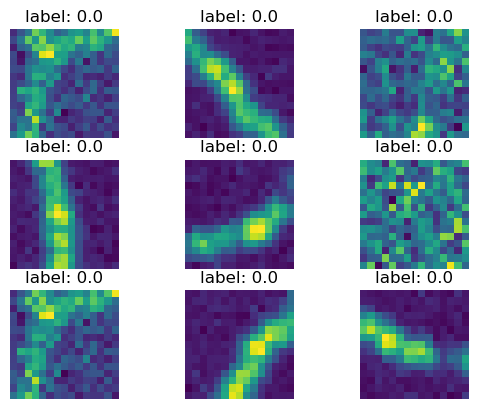

In [7]:
observations = os.listdir(os.path.join(out_dir, "observations"))
training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*_annotations.csv"))[0])
ids = np.random.choice(len(training_annotations), size=9)
sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3, )
ax = ax.flatten()
for i in range(len(ax)):
    img = torch.load(os.path.join(out_dir,"observations", sample.iloc[i,0]), weights_only=True) # type: ignore
    ax[i].imshow(img[0].amax(0))
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

## Instantiate dataloader for training and test datasets
### Dataloaders use a weighted random sampler to balance classes.
### Additionally, the training dataset adds a random permutation and flip to the image patch at retrieval.

In [6]:
# set source data files paths
training_annotations_file = "classifier_data/branch_classifier_neuromorpho_test_02-04-25_test_annotations.csv"
test_annotations_file = "classifier_data/branch_classifier_neuromorpho_test_02-04-25_training_annotations.csv"
img_dir = "classifier_data/observations"

# instantiate training and test datasets
transform = branch_classifier.transform # random permutation and flip
training_data = branch_classifier.StateData(annotations_file=training_annotations_file,
                          img_dir=img_dir,
                          transform=transform)
test_data = branch_classifier.StateData(annotations_file=test_annotations_file,
                          img_dir=img_dir)

# instantiate dataloaders
training_dataloader = branch_classifier.init_dataloader(training_data)
test_dataloader = branch_classifier.init_dataloader(test_data)

## View balanced data

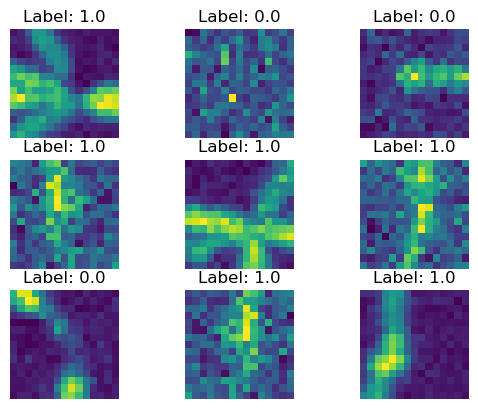

In [16]:
fig, axs = plt.subplots(3,3)
axs = axs.flatten()

X,y = next(iter(training_dataloader))
for i, ax in enumerate(axs):
    ax.imshow(X[i,0].amax(0))
    ax.set_title(f"Label: {y[i]}")
    ax.set_axis_off()

In [10]:
os.listdir('classifier_data')

['branch_classifier_neuromorpho_test_02-04-25_test_annotations.csv',
 'branch_classifier_neuromorpho_test_02-04-25_annotations.csv',
 'observations',
 'branch_classifier_neuromorpho_test_02-04-25_training_annotations.csv']

In [7]:
out_dir = "classifier_weights/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

lr = 1e-3
epochs = 1
classifier = models.ResNet(models.ResidualBlock, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)

branch_classifier.train(training_dataloader, test_dataloader, out_dir, lr, epochs, classifier, state_dict=None)


Epoch 1
-------------------------------
Accuracy: 43.75, Loss: 0.376344  [   64/   67]
Test Error: 
 Accuracy: 49.6%, Avg loss: 3.112986 
           Precision: 0.496, Recall: 1.000
Done!
